### This is a notebook exploring the efficacy of some barebones NLP models on generating new Magic: the Gathering cards and classifying card archetypes. The models seen are by no means final models.

In [ ]:
import json
import pandas as pd
import numpy as np
!pip install fastai --upgrade
!pip install fastcore --upgrade
from fastai.text.all import *

## Load data into dataframe from .json

In [2]:
with open('AllPrintings.json') as f:
    data = json.load(f)

FileNotFoundError: ignored

In [ ]:
set_data = data['data']
all_sets = list(set_data.keys())

Iterate through all sets, storing key attributes of cards to dict

In [ ]:
all_cards = {}
for s in all_sets:
    cards = set_data[s]['cards']
    # import pdb;pdb.set_trace()
    for c in cards:
        name = c.get('name')
        colorID = ''.join(c.get('colorIdentity'))
        colors = ''.join(c.get('colors'))
        cmc = c.get('convertedManaCost')
        mana_cost = c.get('manaCost')
        main_type = c.get('type')
        all_types = ','.join(c.get('types'))
        power = c.get('power')
        toughness = c.get('toughness')
        rarity = c.get('rarity')
        text = c.get('text')
        flavor_text = c.get('flavorText')
        if not name in all_cards:
            all_cards[name] = {'name': name,
                               'colorID': colorID,
                               'colors': colors,
                               'cmc': cmc,
                               'mana_cost': mana_cost,
                               'main_type': main_type,
                               'all_types': all_types,
                               'power': power,
                               'toughness': toughness,
                               'rarity': rarity,
                               'text': text,
                               'flavor_text': flavor_text}

In [ ]:
df = pd.DataFrame(all_cards).T
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
# df.head()

Do some light feature extraction based off features that should be relevant later on

In [ ]:
df['contains_W'] = df['colors'].str.contains('W', case=True, na=False, regex=False)
df['contains_U'] = df['colors'].str.contains('U', case=True, na=False, regex=False)
df['contains_B'] = df['colors'].str.contains('B', case=True, na=False, regex=False)
df['contains_R'] = df['colors'].str.contains('R', case=True, na=False, regex=False)
df['contains_G'] = df['colors'].str.contains('G', case=True, na=False, regex=False)
df['is_colorless'] = df['colors'].eq('')
df['is_multicolor'] = (df['colorID'].str.len() > 1) & (df['main_type'] != 'Land')

In [ ]:
df['is_creature'] = df['all_types'].str.contains('creature|summon', case=False, na=False, regex=True)
df['is_instant'] = df['all_types'].str.contains('instant', case=False, na=False, regex=False)
df['is_enchantment'] = df['all_types'].str.contains('enchantment', case=False, na=False, regex=False)
df['is_sorcery'] = df['all_types'].str.contains('sorcery', case=False, na=False, regex=False)
df['is_artifact'] = df['all_types'].str.contains('artifact', case=False, na=False, regex=False)
df['is_planeswalker'] = df['all_types'].str.contains('planeswalker', case=False, na=False, regex=False)
df['is_land'] = df['all_types'].str.contains('land', case=False, na=False, regex=False)

In [ ]:
df.to_csv('AllPrintings.csv', index=None)
# df.shape # 21317

##Filter data

Some cards have very unique features or are from sets that are holiday/satire oriented. First, filter out through the ```main_type``` & ```all_type``` attributes so that we only have cards that are within a threshold of card types

In [ ]:
df = pd.read_csv('AllPrintings.csv')
df = df.groupby('main_type').filter(lambda x: len(x) > 4)
df = df.groupby('all_types').filter(lambda x: len(x) > 10)
df.shape

Drop cards w/ unusual attributes power/toughness/color attributes. The bulk of these cards are from holiday sets

In [ ]:
drop_power = df.loc[(df['is_creature']) & (~df['power'].isin([str(i) for i in range(20)]))]
drop_toughness = df.loc[(df['is_creature']) & (~df['toughness'].isin([str(i) for i in range(15)]))]
drop_cmc = df.loc[df['cmc'].isin([1000000.0])]
drop_colorID = df.loc[df['colorID'].isin(['GRUW', 'BGRW', 'BGUW', 'BRUW', 'BGRU'])]

all_drops = pd.concat([drop_power, drop_toughness, drop_cmc, drop_colorID])
df.drop(all_drops.index, inplace=True)
df.shape

In [ ]:
df.to_csv('MTGAN.csv', index=None)

In [ ]:
# df.columns

In [ ]:
# df.info()

## Format data for language model
Numericalize text

In [3]:
df = pd.read_csv('MTGAN.csv')
df.shape

(18887, 26)

Drop cards with no ```text``` and/or ```colorID``` attributes. In fine-tuning model, will likely want to include cards w/ no color ID as those represent ~10% of data, but will have to be mindful of how to do this as many will be land cards which should not be included

In [4]:
txt_df = df[df['text'].notnull()] 
txt_df = txt_df[txt_df['colorID'].notnull()] # Maybe I should just replace the nans with some colorless value
print(f"Rows dropped: {df.shape[0] - txt_df.shape[0]}")

Rows dropped: 2424


In [5]:
txts = L(txt_df['text'].to_list())
len(txts)

16463

Tokenize & numericalize text

In [6]:
tkn = Tokenizer(WordTokenizer())
tokens = txts.map(tkn)
tokens[0]

(#60) ['xxbos','xxmaj','if','you','would','draw','a','card',',','you'...]

In [7]:
num = Numericalize(min_freq=5)
num.setup(tkn(tokens))
# coll_repr(num.vocab, 200)

In [8]:
# Apply numericalizer to all text and load into dataloader
numericalized = tokens.map(num)
dl = LMDataLoader(numericalized, bs=128, shuffle=True)

x, y = first(dl)
x.shape, y.shape

(torch.Size([128, 72]), torch.Size([128, 72]))

```fastai``` handles the tokenization & numericalization in the ```TextDataLoaders``` object so will transition to that, but nice to see that the process works as intended here

## Train language model

By default, fastai sets the ```x``` and ```y``` variables in ```LMDataLoader``` to where ```x``` is the numericalized input and ```y``` is the numericalized input shifted over 1. This is because to train a generative language model, the model has to learn the ```n+1``` token. 

Rather than going through explicit tokenization & numericalizaton, use ```TextDataLoaders``` instead

In [9]:
dls = TextDataLoaders.from_df(txt_df, text_col='text', is_lm=True)

In [10]:
model = language_model_learner(dls,
                               AWD_LSTM,
                               drop_mult=0.3,
                               metrics=[accuracy, Perplexity()]).to_fp16()

# model.lr_find() #2e-2

In [11]:
model.fit_one_cycle(1, 2e-2)
model.unfreeze()
model.fit_one_cycle(7, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.229540,1.644342,0.623328,5.177600,00:24


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.564675,1.351149,0.682694,3.861861,00:24
1,1.298771,1.136717,0.730038,3.116520,00:24
2,1.119776,1.060791,0.748565,2.888655,00:24
3,0.993915,1.029428,0.756214,2.799465,00:23
4,0.893552,1.014689,0.762276,2.758505,00:24
5,0.825887,1.010352,0.764421,2.746567,00:23
6,0.782297,1.013263,0.764723,2.754575,00:24


Pretty solid. This should be good to build upon. Let's test some test card generation

In [12]:
# test_txt = "Draw a card for"
# n_words = 100
# n_sentences = 10
# preds = [model.predict(test_txt, n_words) for _ in range(n_sentences)]
# print("\n\n".join(preds))

Pretty cool. Save the encoder to use as classifier

In [13]:
model.save_encoder('language_model')

## Train color classifier

In [14]:
db = DataBlock(blocks=(TextBlock.from_df('text'), CategoryBlock),
               get_x=ColReader('text'),
               get_y=ColReader('colorID'),
               splitter=RandomSplitter(0.2))
dls = db.dataloaders(txt_df)

In [15]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj xxunk to xxunk xxunk ) of xxmaj richard 's xxmaj rules of xxmaj order , at the beginning of the upkeep of each xxunk in this game of the xxmaj magic : xxmaj the xxmaj gathering ® trading card game ( hereafter known as "" player "" ) , that xxup player xxunk all actions in the xxunk of xxunk added actions ( hereafter known as "" action xxup xxunk "" ) , in the order those actions were added , then adds another action to the end of the xxup action xxup xxunk . xxmaj all actions must be xxunk xxunk or xxunk actions that a player can xxunk while xxunk in a xxunk , without xxunk the xxunk and xxunk of xxunk xxup player . \n xxmaj when any xxup player does not xxunk all the xxunk actions in the xxunk order , sacrifice xxmaj xxunk",U
1,"xxbos xxmaj defender ( this creature ca n't attack . ) \n xxmaj when xxmaj xxunk enters the battlefield , you may search your library for any number of cards that have converted mana cost 9 , reveal them , and put them into your hand . xxmaj if you do , shuffle your library . \n { 4 } : xxmaj xxunk loses defender until end of turn . \n xxmaj transmute { 1}{u}{u } ( { 1}{u}{u } , xxmaj discard this card : xxmaj search your library for a card with the same converted mana cost as this card , reveal it , and put it into your hand . xxmaj then shuffle your library . xxmaj transmute only as a sorcery . ) xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",U
2,"xxbos { 1}{w / xxup b } : xxmaj warden of the xxmaj first xxmaj tree becomes a xxmaj human xxmaj warrior with base power and toughness 3 / 3 . \n { 2}{w / xxup b}{w / xxup b } : xxmaj if xxmaj warden of the xxmaj first xxmaj tree is a xxmaj warrior , it becomes a xxmaj human xxmaj spirit xxmaj warrior with trample and lifelink . \n { 3}{w / xxup b}{w / xxup b}{w / xxup b } : xxmaj if xxmaj warden of the xxmaj first xxmaj tree is a xxmaj spirit , put five +1 / +1 counters on it . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",BGW


In [16]:
# txt_df['colorID'].value_counts()

Some of the three color & two color categories are pretty low-N. May be a problem. For now, let's try training a model and seeing how it goes

In [17]:
classifier = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
classifier = classifier.load_encoder('language_model') 
# classifier.lr_find() #3e-3

Train with discriminative learning rates & gradual unfreezing

In [18]:
classifier.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.110026,1.788654,0.503949,00:23


In [19]:
lr_inc = 2.6**4
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.811390,1.590325,0.542224,00:23


In [20]:
# classifier.lr_find() #(2e-3, e-4)

In [21]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.615964,1.422829,0.586877,00:24


In [22]:
classifier.unfreeze()
# classifier.lr_find() #(2e-3, e-4)

In [23]:
classifier.fit_one_cycle(2, slice(2e-3/lr_inc, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.458595,1.288594,0.624848,00:25
1,1.278050,1.201958,0.657959,00:25


In [24]:
# classifier.lr_find() #3e-3

In [25]:
classifier.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.316695,1.222355,0.649757,00:25
1,1.074185,1.002358,0.715978,00:25
2,0.815714,0.926399,0.741495,00:25
3,0.588125,0.938390,0.738761,00:25


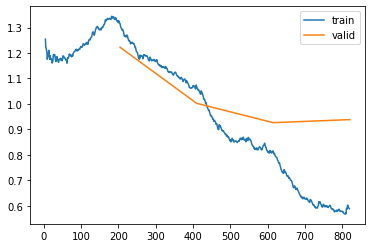

In [26]:
classifier.recorder.plot_loss()

Looks like this is as good as we're going to get. Probably try a multilabel classification instead? With how MTG is setup, this may be a better choice, especially given the low-N of double & tri-colored cards.

Let's see where we're going wrong

In [ ]:
interp = ClassificationInterpretation.from_learner(classifier)
interp.most_confused(min_val=15)

In [ ]:
interp.print_classification_report()

A couples things noteworthy here:
1. The bulk of misclassified data is single-colored. There's likely an effect of single-colored being overrepresented in the dataset as a whole so this isn't too surprising, but I was expected multicolored cards to have greater error prominence
2. As expected, the f1 scores of single colored cards averages around 75% whereas double-colored is around 40-60% and tricolored varies wildly.

Let's try a multilabel classifier. It's likely this'll be what we want anyways as, despite each color combination having a unique identity & feel, the color combinations are made up of their constituent colors

## Train multilabel classifier

Reformat the label category to make it easier for the learner

In [53]:
def split_whitespace(c):
    splits = list(c)
    return " ".join(splits)

txt_df['colorID'] = txt_df['colorID'].apply(split_whitespace)

In [54]:
def get_color_labels(r):
    return r['colorID'].split(" ")

db = DataBlock(blocks=(TextBlock.from_df('text'), MultiCategoryBlock),
               get_x=ColReader('text'),
               get_y=get_color_labels,
               splitter=RandomSplitter(0.2))

dls = db.dataloaders(txt_df)

In [ ]:
# dls.show_batch(max_n=3)

Train model similar to above, but a bit more liberal with learning rates

In [80]:
multiclass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy_multi).to_fp16()
multiclass = multiclass.load_encoder('language_model') 
# multiclass.lr_find() #3e-3

In [81]:
multiclass.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.583173,0.417817,0.825334,00:25


In [82]:
multiclass.freeze_to(-2)
# multiclass.lr_find() # 1e-3

In [83]:
multiclass.fit_one_cycle(2, slice(1e-3/lr_inc, 1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.512368,0.396333,0.834802,00:26
1,0.472430,0.384421,0.840371,00:26


In [84]:
multiclass.freeze_to(-4)
# multiclass.lr_find() # 4e-2 should be fine

In [85]:
multiclass.fit_one_cycle(2, slice(4e-2/lr_inc, 4e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.366328,0.315539,0.881379,00:27
1,0.296507,0.258033,0.903554,00:27


90% accuracy before final unfreezing, pretty good!

In [88]:
multiclass.unfreeze()
# multiclass.lr_find() # 2e-5 to 2e-3

In [89]:
multiclass.save('multiclass_penultimate')

Path('models/multiclass_penultimate.pth')

In [94]:
multiclass = multiclass.load('multiclass_penultimate')
multiclass.fit_one_cycle(3, lr_max=slice(2e-5, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.256318,0.253008,0.906288,00:27
1,0.243068,0.248292,0.908161,00:27
2,0.235425,0.248502,0.907858,00:27


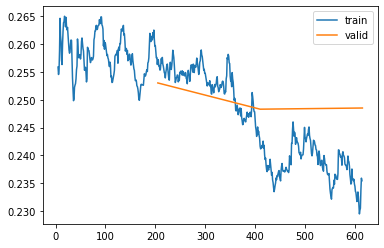

In [95]:
multiclass.recorder.plot_loss()

Able to squeeze out an extra % or so from training the unfrozen model. Overall pretty happy with this barebones model performance!

## Fine-tuning next steps
1. Label data w/ no ```colorID``` attribute such that truly colorless cards are represented while lands aren't
2. Augment the dataset. Current data is a bit sparse.
3. Filter the text more to handle tokens such as `{T}` more effectively. This will be important to produce realistic cards given MTG's reliance on these symbols
4. Apply ULMFiT to train language model - right now just trained on MTG card text data which isn't that comprehensive